In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from tensorflow.keras.layers import LSTM
from kerastuner.tuners import RandomSearch
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, Dense, Bidirectional, GRU
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.models import Model
import os
from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from tensorflow.python.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, accuracy_score, f1_score
import keras.backend as K
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import codecs
from tqdm import tqdm
from kerastuner import HyperParameters, Objective
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from ipykernel import kernelapp as app


In [4]:
os.chdir("/content/drive/MyDrive/TextAnalytics - AMI 2020/dataset")

In [5]:
## TRAINING SET
ami_csv = "training_set_cleaned.csv"
df = pd.read_csv(ami_csv)

In [6]:
#Global Parameters
max_len = 35
EPOCHS = 40
BATCH_SIZE= 128
EARLY_STOPPING_PATIENCE = 5 #If the f1 does not increase after this epochs, break the process 
NUM_CLASSES = 2 # mysog or not mys

In [7]:
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [8]:
def plot_history(history):
    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(f1_score) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, f1_score, 'b', label='Training F1 Score')
    plt.plot(x, val_f1_score, 'r', label='Validation F1 Score')
    plt.title('Training and validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend()

In [9]:
def eval_model(model,X_train,X_val,y_train,y_val):
  # Find train and test f1
  loss, f1 = model.evaluate(X_train, y_train, verbose=False)
  print("Training F1 Score: {:.4f}".format(f1))
  loss, f1 = model.evaluate(X_val, y_val, verbose=False)
  print("Validation F1 Score:  {:.4f}".format(f1))

  y_prob = model.predict(X_val)
  y_pred = y_prob.round()
  print(classification_report(y_val, y_pred))
  confusion_matrix(y_val, y_pred)

In [10]:
def split_tokenize_padding(df, resample=False):
  ## SPLIT in Training Set and Validation Set stratify based on target variable
  train, val = train_test_split(df, 
                                stratify=df['target'],
                                test_size=0.2, random_state=42)
  if (resample):
    train_new = train.copy()
    temp_train = train_new.iloc[np.random.choice(np.where(train_new['target']==1)[0], size=1096)]
    train = train_new.append(temp_train, ignore_index=True)
  
  X_train = train["final_text_tag"]
  y_agr_train = train["aggressiveness"]
  y_mys_train = train["misogynous"]
  y_mlc_train = train["target"]

  X_val = val["final_text_tag"]
  y_agr_val = val["aggressiveness"]
  y_mys_val = val["misogynous"]
  y_mlc_val = val["target"]
  
  # we know from DU that most tweets have lenght of about 35, just very few exceed that len.
  # we can then perform a padding operation so that all tweets have same len of 35. 
  max_len = 35

  ## VAL SET
  tokenizer = Tokenizer()
  # populate a vocabulary of all unique tokens
  tokenizer.fit_on_texts(X_val)
  # tokenize each tweets into tokens and then retrieve indexes of those tokens from the vocabulary
  sequences = tokenizer.texts_to_sequences(X_val) 
  # padding to 35
  padsequences = pad_sequences(sequences, maxlen= max_len)
  X_val = padsequences

  ## TRAIN SET
  tokenizer = Tokenizer()
  # populate a vocabulary of all unique tokens
  tokenizer.fit_on_texts(X_train)
  # tokenize each tweets into tokens and then retrieve indexes of those tokens from the vocabulary
  sequences = tokenizer.texts_to_sequences(X_train) 
  padsequences = pad_sequences(sequences, maxlen= max_len)
  X_train = padsequences

  return tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val

In [47]:
def build_RNN(best_hps, n_class = 1):

  model = Sequential()
  
  model.add(Embedding(
          input_dim = vocab_len, 
          output_dim = embedding_len, 
          weights=[matrix_embedding], 
          input_length=35 ,
          trainable=False))
  
  model.add(LSTM(best_hps.get("LSTM_layer"), 
                recurrent_dropout = best_hps.get("drop1")))
  
  model.add(Dense(n_class,
                    kernel_regularizer= tf.keras.regularizers.l2(best_hps.get("regularizer_2")), 
                    activation='sigmoid',
                    name='classifier'))
  
  lr = best_hps.get("learning_rate")
  opt = keras.optimizers.Adam(learning_rate=lr)
  # # Compile the model 
  # if (n_class==3):
  #   model.compile(optimizer=opt, 
  #             loss="categorical_crossentropy", 
  #             metrics=["acc"])
  # else:
  model.compile(optimizer=opt, 
        loss="sparse_categorical_crossentropy", 
        metrics=["acc"])
    
  
  model.summary()

  return model

In [12]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val  = split_tokenize_padding(df)

In [13]:
# load Glove Embeddings in memory from the file
# we return a dictionary (glove_embeddings) whose keys are tokens and values are the embeddings

glove_dict = {}
with open("glove.6B.100d.txt") as f:
    for text in f:
        try:
            token = text.split()
            key = token[0]
            values = token[1:]
            glove_dict[key] = np.array(values, dtype=np.float32)
        except:
            continue
f.close()

In [14]:
# build matrix Of GloVe embeddings
def build_matrixGlove():
  embedding_len = 100
  vocab_len = len(tokenizer.index_word) + 1

  matrix_embedding = np.zeros((vocab_len, embedding_len))

  # vocabulary tokens (tweets)
  word_index = tokenizer.word_index

  word_index

  for word , idx in word_index.items():
    # retrive word from glove_dict and put it in the matrix, if it is not present then it return a numpy array with embedding len zeros
    matrix_embedding[idx] = glove_dict.get(word, np.zeros(embedding_len))
  return matrix_embedding, embedding_len, vocab_len

In [49]:
matrix_embedding, embedding_len, vocab_len = build_matrixGlove()

In [15]:
n_class = 1

In [22]:
earlyStopper = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

In [37]:
# takes a tuner object as input to tune hyper-parameters

def tune_RNN(tuner):

  model = Sequential()

  # Embedding
  model.add(Embedding(
          input_dim = vocab_len, 
          output_dim = embedding_len, 
          weights=[matrix_embedding], 
          input_length=35 ,
          trainable=False))

  # Bidirectional LSTM
  model.add(
          LSTM(tuner.Int('LSTM_layer',min_value=32,max_value=512,step=32), 
          return_sequences = True, 
          recurrent_dropout=tuner.Float('drop1', 0, 0.5, step=0.1, default=0.5)))

  # Sigmoid Classificator
  model.add(Dense(n_class,
                  kernel_regularizer= tf.keras.regularizers.l2(
                    tuner.Float(
                      'regularizer_2',
                      min_value=1e-4,
                      max_value=1e-1,
                      sampling='LOG',
                      default=1e-2
                  )), 
                activation='sigmoid',
                name='classifier'))
  
  # Learning Rate initialization
  lr = tuner.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3])
  opt = keras.optimizers.Adam(learning_rate=lr)
  
  # # Compile the model 
  if (n_class==3):
    model.compile(optimizer=opt, 
              loss="sparse_categorical_crossentropy", 
              metrics=["acc"])
  else:
    model.compile(optimizer=opt, 
          loss="binary_crossentropy", 
          metrics=[f1_score])
    
  model.summary()
  return model

In [27]:
def tuner_search_print(y_train,projectname,n_class=1):

  if (n_class == 3): 
    obj = 'val_acc'
  else:
    obj = 'val_f1_score'

  tuner = kt.Hyperband(hypermodel = tune_RNN,
                     objective = Objective(obj, direction='max'),
                     max_epochs = 40, directory='dataset/RNN/', seed=43,
                     project_name=projectname)
  
  tuner.search(X_train, y_train, epochs=EPOCHS, validation_split=0.1, callbacks=[earlyStopper])

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best value of bilsmt: {}".format(best_hps.get("LSTM_layer")))

  print("Best value of drop1: {}".format(best_hps.get("drop2")))
  # print("Best value of drop2: {}".format(best_hps.get("drop2")))
  # print("Best value of drop3: {}".format(best_hps.get("drop3")))

  print("Best value of LR: {:.4f}".format(best_hps.get("learning_rate")))

  # print("Best value of regularizer_1: {:.4f}".format(best_hps.get("regularizer_1")))
  print("Best value of regularizer_2: {:.4f}".format(best_hps.get("regularizer_2")))
  
  return best_hps

In [18]:
best_hps_mys = tuner_search_print(y_mys_train,'hyperband_tuner_rnnMYS1')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           819600    
                                                                 
 lstm (LSTM)                 (None, 35, 32)            17024     
                                                                 
 classifier (Dense)          (None, 35, 1)             33        
                                                                 
Total params: 836,657
Trainable params: 17,057
Non-trainable params: 819,600
_________________________________________________________________
Best value of bilsmt: 160
Best value of drop1: 0.30000000000000004
Best value of LR: 0.0010
Best value of regularizer_2: 0.0001


In [26]:
model_mys = build_RNN(best_hps_mys)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 35, 100)           819600    
                                                                 
 lstm_4 (LSTM)               (None, 160)               167040    
                                                                 
 classifier (Dense)          (None, 1)                 161       
                                                                 
Total params: 986,801
Trainable params: 167,201
Non-trainable params: 819,600
_________________________________________________________________


In [27]:
model_mys_fit = model_mys.fit(X_train, y_mys_train,
                    validation_split = 0.1,
                    epochs=40, batch_size=BATCH_SIZE)

Epoch 1/40
25/25 [==============================] - 10s 284ms/step - loss: 0.6339 - f1_score: 0.5946 - val_loss: 0.5885 - val_f1_score: 0.7204
Epoch 2/40
25/25 [==============================] - 7s 266ms/step - loss: 0.5682 - f1_score: 0.7024 - val_loss: 0.5584 - val_f1_score: 0.6865
Epoch 3/40
25/25 [==============================] - 7s 265ms/step - loss: 0.5249 - f1_score: 0.7189 - val_loss: 0.5656 - val_f1_score: 0.6650
Epoch 4/40
25/25 [==============================] - 7s 264ms/step - loss: 0.5057 - f1_score: 0.7169 - val_loss: 0.5704 - val_f1_score: 0.6958
Epoch 5/40
25/25 [==============================] - 7s 266ms/step - loss: 0.4886 - f1_score: 0.7384 - val_loss: 0.5661 - val_f1_score: 0.6894
Epoch 6/40
25/25 [==============================] - 7s 263ms/step - loss: 0.4718 - f1_score: 0.7490 - val_loss: 0.5355 - val_f1_score: 0.7118
Epoch 7/40
25/25 [==============================] - 7s 264ms/step - loss: 0.4628 - f1_score: 0.7538 - val_loss: 0.5279 - val_f1_score: 0.6989
Epoch

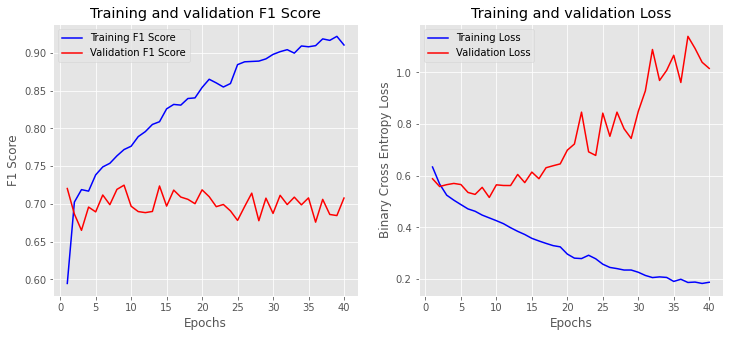

In [28]:
plot_history(model_mys_fit)

Training F1 Score: 0.9082
Validation F1 Score:  0.5943
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       471
           1       0.59      0.60      0.60       409

    accuracy                           0.62       880
   macro avg       0.62      0.62      0.62       880
weighted avg       0.62      0.62      0.62       880



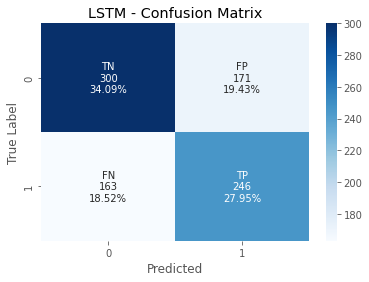

In [31]:
# Find train and test f1
loss, f1 = model_mys.evaluate(X_train, y_mys_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model_mys.evaluate(X_val, y_mys_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model_mys.predict(X_val)
y_pred_mys = y_prob.round()
                    
print(classification_report(y_mys_val, y_pred_mys))
confusion_matrix(y_mys_val, y_pred_mys)

cf_matrix = confusion_matrix(y_mys_val, y_pred_mys)
make_confusion_matrix(cf_matrix, 'LSTM - Confusion Matrix')

In [34]:
best_hps_agr = tuner_search_print(y_agr_train,'hyperband_tuner_rnnAGR1')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           819600    
                                                                 
 lstm_1 (LSTM)               (None, 35, 32)            17024     
                                                                 
 classifier (Dense)          (None, 35, 3)             99        
                                                                 
Total params: 836,723
Trainable params: 17,123
Non-trainable params: 819,600
_________________________________________________________________
Best value of bilsmt: 512
Best value of drop1: 0.4
Best value of LR: 0.0100
Best value of regularizer_2: 0.0089


In [33]:
model_agr = build_RNN(best_hps_agr)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 35, 100)           819600    
                                                                 
 lstm_6 (LSTM)               (None, 512)               1255424   
                                                                 
 classifier (Dense)          (None, 1)                 513       
                                                                 
Total params: 2,075,537
Trainable params: 1,255,937
Non-trainable params: 819,600
_________________________________________________________________


In [ ]:
tf.keras.utils.plot_model(model_agr)

In [34]:
model_agr_fit = model_agr.fit(X_train, y_agr_train,
                    validation_split = 0.1,
                    epochs=40, batch_size=BATCH_SIZE)

Epoch 1/40
25/25 [==============================] - 37s 1s/step - loss: 0.7242 - f1_score: 0.2112 - val_loss: 0.6684 - val_f1_score: 0.0000e+00
Epoch 2/40
25/25 [==============================] - 34s 1s/step - loss: 0.6645 - f1_score: 0.0531 - val_loss: 0.6587 - val_f1_score: 0.0819
Epoch 3/40
25/25 [==============================] - 33s 1s/step - loss: 0.6403 - f1_score: 0.1265 - val_loss: 0.6413 - val_f1_score: 0.1909
Epoch 4/40
25/25 [==============================] - 36s 1s/step - loss: 0.6135 - f1_score: 0.3066 - val_loss: 0.6285 - val_f1_score: 0.2188
Epoch 5/40
25/25 [==============================] - 36s 1s/step - loss: 0.5916 - f1_score: 0.4501 - val_loss: 0.5994 - val_f1_score: 0.4637
Epoch 6/40
25/25 [==============================] - 34s 1s/step - loss: 0.5705 - f1_score: 0.5204 - val_loss: 0.6121 - val_f1_score: 0.4835
Epoch 7/40
25/25 [==============================] - 34s 1s/step - loss: 0.5578 - f1_score: 0.5081 - val_loss: 0.5802 - val_f1_score: 0.6073
Epoch 8/40
25/25

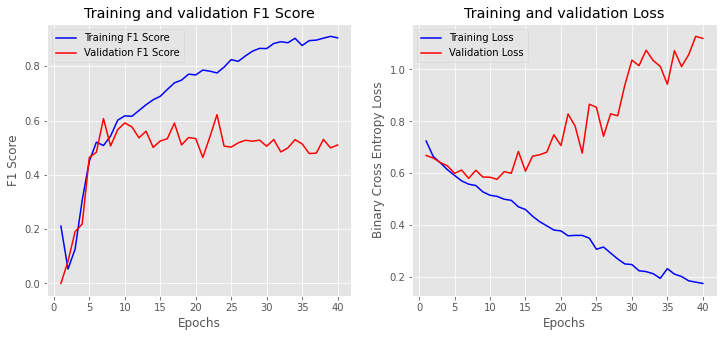

In [36]:
plot_history(model_agr_fit)

Training F1 Score: 0.8772
Validation F1 Score:  0.4214
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       566
           1       0.46      0.40      0.43       314

    accuracy                           0.62       880
   macro avg       0.57      0.57      0.57       880
weighted avg       0.61      0.62      0.61       880



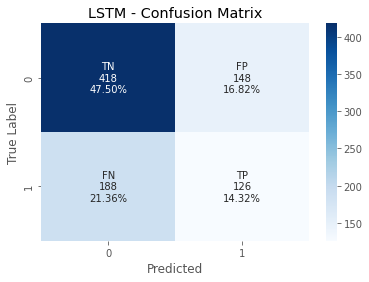

In [37]:
# Find train and test f1
loss, f1 = model_agr.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model_agr.evaluate(X_val, y_agr_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model_agr.predict(X_val)
y_pred = y_prob.round()
                    
print(classification_report(y_agr_val, y_pred))
confusion_matrix(y_agr_val, y_pred)

cf_matrix = confusion_matrix(y_agr_val, y_pred)
make_confusion_matrix(cf_matrix, 'LSTM - Confusion Matrix')

In [38]:
## second testing strategy
itemindex = np.where(y_pred_mys == 1)
X_val_agr = X_val[itemindex[0]]
y_prob = model_agr.predict(X_val_agr)
y_pred_agr = y_prob.round()
y_agr_val.reset_index(inplace=True, drop=True)                    

# Find train and test f1
loss, f1 = model_agr.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model_agr.evaluate(X_val_agr, y_agr_val[itemindex[0]], verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

print(classification_report(y_agr_val[itemindex[0]], y_pred_agr))
confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

cf_matrix = confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

Training F1 Score: 0.8772
Validation F1 Score:  0.5125
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       230
           1       0.52      0.60      0.56       187

    accuracy                           0.57       417
   macro avg       0.57      0.58      0.57       417
weighted avg       0.58      0.57      0.57       417



In [62]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df,True)

In [32]:
matrix_embedding, embedding_len, vocab_len  = build_matrixGlove()

In [57]:
encoder = LabelEncoder()
y_mlc_train = encoder.fit_transform(y_mlc_train)

In [58]:
y_mlc_val = encoder.fit_transform(y_mlc_val)

In [44]:
y_mlc_train

array([0, 0, 0, ..., 1, 1, 1])

In [54]:
y_mlc_train = to_categorical(y_mlc_train, num_classes=3)
y_mlc_val = to_categorical(y_mlc_val, num_classes=3)

In [24]:
n_class = 3

In [74]:
best_hps_mlc = tuner_search_print(y_mlc_train,'hyperband_tunermlcRNN')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           819600    
                                                                 
 lstm_1 (LSTM)               (None, 35, 32)            17024     
                                                                 
 classifier (Dense)          (None, 35, 3)             99        
                                                                 
Total params: 836,723
Trainable params: 17,123
Non-trainable params: 819,600
_________________________________________________________________
Best value of bilsmt: 512
Best value of drop1: 0.4
Best value of LR: 0.0100
Best value of regularizer_2: 0.0089


In [48]:
model = build_RNN(best_hps_mlc, 3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 100)           819600    
                                                                 
 lstm_3 (LSTM)               (None, 512)               1255424   
                                                                 
 classifier (Dense)          (None, 3)                 1539      
                                                                 
Total params: 2,076,563
Trainable params: 1,256,963
Non-trainable params: 819,600
_________________________________________________________________


In [49]:
batch_size=128

model_fit = model.fit(X_train, y_mlc_train,
          validation_split = 0.10,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/40
33/33 [==============================] - 53s 2s/step - loss: 1.1036 - acc: 0.4894 - val_loss: 1.3839 - val_acc: 0.0952
Epoch 2/40
33/33 [==============================] - 59s 2s/step - loss: 0.9070 - acc: 0.5812 - val_loss: 1.1919 - val_acc: 0.3680
Epoch 3/40
33/33 [==============================] - 48s 1s/step - loss: 0.8220 - acc: 0.6439 - val_loss: 0.9033 - val_acc: 0.6104
Epoch 4/40
33/33 [==============================] - 50s 2s/step - loss: 0.7114 - acc: 0.7087 - val_loss: 0.7065 - val_acc: 0.7229
Epoch 5/40
33/33 [==============================] - 45s 1s/step - loss: 0.6148 - acc: 0.7614 - val_loss: 0.5819 - val_acc: 0.8009
Epoch 6/40
33/33 [==============================] - 45s 1s/step - loss: 0.5462 - acc: 0.7937 - val_loss: 0.5672 - val_acc: 0.7771
Epoch 7/40
33/33 [==============================] - 49s 1s/step - loss: 0.4825 - acc: 0.8234 - val_loss: 0.3628 - val_acc: 0.8723
Epoch 8/40
33/33 [==============================] - 45s 1s/step - loss: 0.4125 - acc: 0.85

In [59]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mlc_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mlc_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

Training F1 Score: 0.4948
Validation F1 Score:  0.5682


In [72]:
y_prob = model.predict(X_val)
y_pred = y_prob.round()
y_pred = np.argmax(y_pred, axis=1)

y_mlc_val = np.argmax(y_mlc_val, axis=1)

print(classification_report(y_mlc_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.86      0.74       471
           1       0.13      0.16      0.14        95
           2       0.52      0.22      0.31       314

    accuracy                           0.56       880
   macro avg       0.43      0.41      0.40       880
weighted avg       0.54      0.56      0.52       880

